# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
from udacity_model import Actor, Critic
from udacity_replay_buffer import ReplayBuffer, ActionNoise
from udacity_agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

agent = Agent(state_size, action_size, 7654321)

def play_reacher(n_episodes=1000, print_every=100, EPS=1.0, eps_decay=0.992, eps_floor=0.05):
    
    # Keep track of scores over episodes
    scores_window = deque(maxlen=print_every)
    training_scores = []
    
    for i_episode in range(1, n_episodes+1):
        
        # Gen environment info
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # Keep track of score within episode
        episode_scores = np.zeros(num_agents)
        
        # Reset the noise process
        agent.reset()
        
        while True:
            
            # Act, step through env and record states
            actions = agent.act(states, EPS)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # Agent steps and trains
            agent.step(states, actions, rewards, next_states, dones)
            
            # Update state, accumulate reward, break if done
            states = next_states
            episode_scores += rewards
            if np.any(dones):
                break
        
        # Add scores to lists
        scores_window.append(episode_scores)
        training_scores.append(episode_scores)
        
        # Update epsilon
        EPS = max(EPS*eps_decay,eps_floor)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            # Save the successful model weights
            torch.save(agent.actor_local.state_dict(), 'actor_local.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_local.pth')
            break
        
    return training_scores

scores = play_reacher()
env.close()


Episode 100	Average Score: 1.38
Episode 200	Average Score: 8.87
Episode 300	Average Score: 21.01
Episode 400	Average Score: 21.80
Episode 500	Average Score: 26.21
Episode 577	Average Score: 30.11
Environment solved in 477 episodes!	Average Score: 30.11


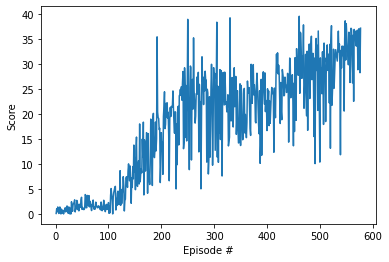

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()